Why did Bessie the cow give her dad a construction hat before bed? 

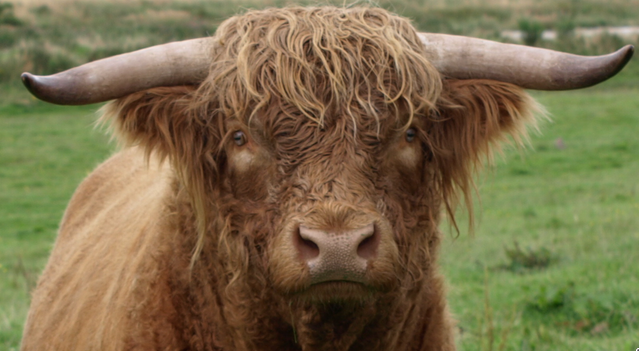

_Because he's a bull-dozer!_

It's time for the [kaggle bulldozer challenge](https://www.kaggle.com/competitions/bluebook-for-bulldozers/)!

This notebook can be found here: [bulldozers.ipynb](https://github.com/johnshaughnessy/digits/blob/main/bulldozers.ipynb).

# What I've done so far

**Set Baseline**

In [`tractors.ipynb`](https://github.com/johnshaughnessy/digits/blob/main/tractors.ipynb), I created a baseline model. Since my goal was to get an end-to-end training process working, I tried to choose simplicity of implementation over accuracy of results anytime the tradeoff was presented.

**Add Utility Functions**

I wrote a utility function called `get_kaggle_dataset` and put it in `util.py` because it seems like something I'll need to do again and again for every competition. 

**Simplify**

In the spirit of simplicity, I dropped all but a few columns from my dataset: `'SalesID', 'SalePrice', 'YearMade', 'saledate'`. 

Features are either continuous or categorical. For example,
- **Continuous** : Height (centimeters). 
- **Categorical** : US States 

Sometimes single features in the dataset should be broken into multiple simpler features so that models have enough structure to glom onto to find the most useful patterns. Dates are a great example.  I transformed `saledate` into a set of simpler date-related features using `add_datepart`:

```
from fastai.tabular.core import add_datepart
add_datepart(df, 'saledate', drop=True)
```

Thus `saledate` became:

- saleYear
- saleMonth
- saleWeek
- saleDay
- saleDayofweek
- saleDayofyear
- saleIs_month_end
- saleIs_month_start
- saleIs_quarter_end
- saleIs_quarter_start
- saleIs_year_end
- saleIs_year_start
- saleElapsed

**Clean**

(Without knowing whether this would make a positive difference on my results or not), I set the `YearMade` date of all the records that reported `YearMade == 1000` to 10 less than the minimum, and added a `YearMade_imputed` feature that flagged every row that I did this to.

```
df['YearMade_imputed'] = (df['YearMade'] == 1000).astype(int)
next_smallest_value = df[df['YearMade'] > 1000]['YearMade'].min()
df['YearMade'] = np.where(df['YearMade'] == 1000, next_smallest_value - 10, df['YearMade'])
```

**Inspect**

I "looked" at the data in a number of ways:
- I listed the categories
- I computed the correlation matrix of the numeric features
- I computed the number of unique entries for each category

**`Scikit-learn`**

I used a few functions from the `scikit-learn` library:

```
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
```

**`train_test_split`**

I prepared a `DataFrame` (`df`) with training and validation data, which I split into `X` and `y`. `X` contains the "independent variables" (that is, the features that will be available to me in my test set) and `y` contains the the "dependent variables" (that is, the thing I'm trying to predict). In this case, I'm trying to predict the `'SalePrice'` feature, so I pull that out of `df` as `y`:

```
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
```

I use `train_test_split` to randomly select 20% of the data to use as my validation set:

```
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
```


**`RandomForestRegressor`**

I create a `RandomForestRegressor` (`rf`);
```
rf = RandomForestRegressor(n_estimators= 10, max_depth=10, min_samples_leaf=4, n_jobs=-1, random_state=42, verbose=2)
```
train it;
```
rf.fit(X_train, y_train)
```
and use it to make a prediction on the validation set:
```
y_pred = rf.predict(X_val)
```

**mean_squared_log_error**

I need some measure by which to evaluate the quality of this model. The contest uses mean squared log error, which is a common measure.

It's very easy to calculate:

```
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f'Root Mean Squared Log Error: {rmsle}')
```

In this case, we got
```
Root Mean Squared Log Error: 0.4940258178377561
```

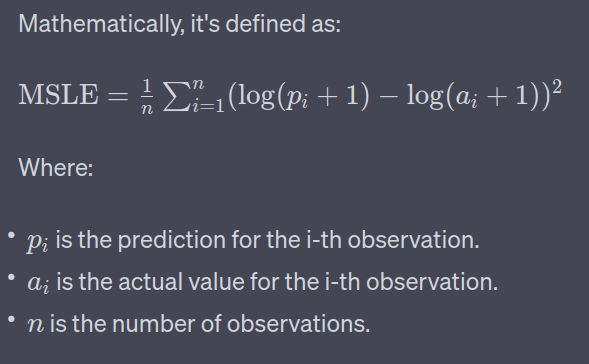

The math is harder for me to understand than code, so here it is as code:

```
def msle(predicted, actual):
    return np.mean((np.log(predicted + 1) - np.log(actual + 1))**2)
```

We can plot `msle` in a graph to understand its shape:

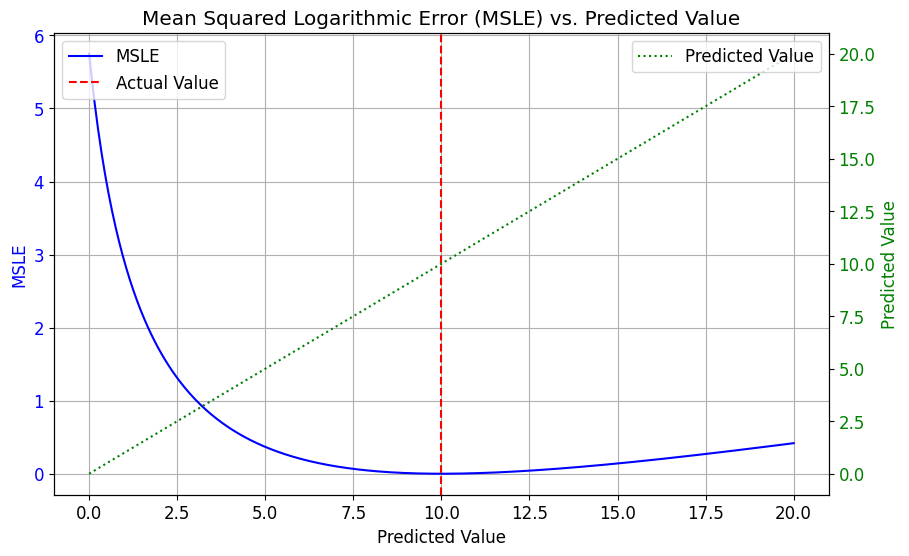

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def msle(predicted, actual):
    return np.mean((np.log(predicted + 1) - np.log(actual + 1))**2)

# Set a fixed actual value
actual_val = 10

# Generate a range of predicted values around the actual value
predicted_vals = np.linspace(0, 20, 400)

# Calculate the MSLE for each predicted value
errors = [msle(np.array([pred]), np.array([actual_val])) for pred in predicted_vals]

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot MSLE values on the primary y-axis
ax1.plot(predicted_vals, errors, label='MSLE', color='b')
ax1.axvline(actual_val, color='r', linestyle='--', label='Actual Value')
ax1.set_title('Mean Squared Logarithmic Error (MSLE) vs. Predicted Value')
ax1.set_xlabel('Predicted Value')
ax1.set_ylabel('MSLE', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')
ax1.grid(True)

# Add a secondary y-axis to show the predicted values
ax2 = ax1.twinx()
ax2.plot(predicted_vals, predicted_vals, label='Predicted Value', color='g', linestyle=':')
ax2.set_ylabel('Predicted Value', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')

plt.show()


**`mean_absolute_error`**
I wanted a more intuitive understanding of the error, so I calculated the mean absolute error which was $11469.66:

```
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_val, y_pred)
```

I also plotted a histogram of the errors:

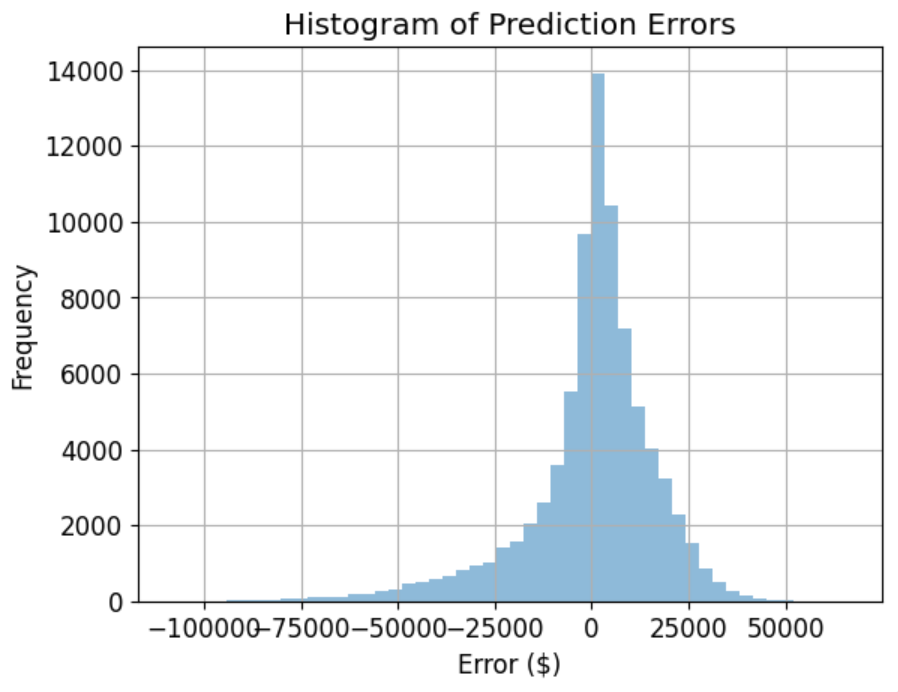

# What to do next

Now that I have a baseline model, the name of the game is to try to improve it.

Here are some ideas for improving the model (and the workflow):
- Include more of the original features in the training data, so that the model has more to work with.
- Reduce the size of the training set to increase my iteration speed. I can probably improve the model while working on just a small random subset of the training data.
- Include features that are in the supplemental CSV file. So far, I'm ignoring whatever useful signals are there.

# Get started

In [112]:
from util import get_kaggle_dataset
import pandas as pd
path = get_kaggle_dataset("bluebook-for-bulldozers")
df = pd.read_csv(path/f'TrainAndValid.csv', low_memory=False) 

## Combine CSV files into a larger `DataFrame`

In [113]:
len(df.columns)

53

In [114]:
def add(df, csv):
    df_supp = pd.read_csv(path/f'{csv}', low_memory=False)
    common_columns = list(set(df.columns) & set(df_supp.columns))
    return pd.merge(df, df_supp, on=common_columns, how='left')

df = add(df, 'Machine_Appendix.csv')

In [115]:
len(df.columns)

59

## Reduce the size of the training set

Let's randomly select some number of rows from the data frame.

In [116]:
len(df)

412698

In [117]:
df = df.sample(frac=0.1, random_state=42)

In [118]:
len(df)

41270

## Preparing Columns

In [119]:
# For numerical columns
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

# For categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [82]:
# df.nunique()

In [122]:
# Step 1: One-hot encode columns with fewer than 20 unique values
# cols_to_onehot = [col for col in df.columns if df[col].nunique() < 20]
# df = pd.get_dummies(df, columns=cols_to_onehot, drop_first=True)
# 
# df = df.copy()

# Step 2: Transform 'saledate' into date-related fields
from fastai.tabular.core import add_datepart
add_datepart(df, 'saledate', drop=True)

# df = df.copy()

# Step 4: Drop SalesID, ModelID, MachineID
# df.drop(['SalesID', 'ModelID', 'MachineID'], axis=1, inplace=True)

# df = df.copy()

# y = df['SalePrice']
# Step 5: Drop ordinal features with 20+ unique values
# cols_to_drop = [col for col in df.columns if df[col].nunique() >= 20]
# df.drop(cols_to_drop, axis=1, inplace=True)
# 
# df = df.copy()

# The resulting df is ready for modeling
df.head()

/home/john/.local/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,MfgYear,fiManufacturerID,fiManufacturerDesc,PrimarySizeBasis,PrimaryLower,PrimaryUpper,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
148588,1521781,21000.0,1507963,4199,132,2.0,1988,0.0,Medium,E110B,E110,B,II,LGP,Small,"Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons",New York,TEX,Track Excavators,Two Wheel Drive,EROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,None or Unspecified,14',None or Unspecified,No,Standard,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Steel,20 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,PAT,None or Unspecified,Standard,Conventional,1988.0,26.0,Caterpillar,Weight - Metric Tons,11.0,12.0,2001,4,16,21,5,111,False,False,False,False,False,False,9.878112e+08
246811,1758060,37000.0,1349729,16679,132,1.0,2005,7565.0,High,WA250-5,WA250,C,-5,LGP,Medium,Wheel Loader - 120.0 to 135.0 Horsepower,Texas,WL,Wheel Loader,Two Wheel Drive,EROPS w AC,Yes,None or Unspecified,None or Unspecified,Standard,Standard,None or Unspecified,None or Unspecified,14',None or Unspecified,No,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,20.5,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,PAT,None or Unspecified,Standard,Conventional,2005.0,103.0,Komatsu,Horsepower,120.0,135.0,2010,6,23,7,0,158,False,False,False,False,False,False,1.275869e+09
196162,1634075,14000.0,1273985,4579,132,7.0,1999,0.0,Medium,210LE,210,LE,II,LGP,Compact,Wheel Loader - 60.0 to 80.0 Horsepower,South Carolina,WL,Wheel Loader,Two Wheel Drive,OROPS,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Standard,None or Unspecified,None or Unspecified,14',None or Unspecified,No,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,PAT,None or Unspecified,Standard,Conventional,1999.0,43.0,John Deere,Horsepower,60.0,80.0,2007,10,42,18,3,291,False,False,False,False,False,False,1.192666e+09
94981,1406718,37000.0,1411309,7054,132,1.0,1995,0.0,Medium,311,311,C,II,LGP,Small,"Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons",California,TEX,Track Excavators,Two Wheel Drive,EROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,None or Unspecified,14',None or Unspecified,No,Standard,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,PAT,None or Unspecified,Standard,Conventional,1995.0,26.0,Caterpillar,Weight - Metric Tons,11.0,12.0,1998,8,33,11,1,223,False,False,False,False,False,False,9.027936

In [76]:
# Don't need to scale: We plan to use trees, not neural nets

# from sklearn.preprocessing import StandardScaler
# 
# scaler = StandardScaler()
# df[df.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(df.select_dtypes(include=[np.number]))

In [123]:
from sklearn.model_selection import train_test_split

# X = df

X = df.drop('SalePrice', axis=1)
y = df['SalePrice'] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    
    # Combine train and val to find all unique categories
    unique_values = pd.concat([X_train[col], X_val[col]], ignore_index=True).unique()
    
    # Add "Unknown" category
    le.fit(list(unique_values) + ['Unknown'])
    
    X_train[col] = X_train[col].map(lambda s: 'Unknown' if s not in le.classes_ else s)
    X_train[col] = le.transform(X_train[col])
    
    X_val[col] = X_val[col].map(lambda s: 'Unknown' if s not in le.classes_ else s)
    X_val[col] = le.transform(X_val[col])
    
    label_encoders[col] = le


In [130]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, max_depth=10, min_samples_leaf=4, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=10,
                      n_jobs=-1, random_state=42)

In [131]:
y_pred = rf.predict(X_val)

ValueError: could not convert string to float: 'D8K'

In [89]:
from sklearn.metrics import mean_squared_log_error
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
rmsle

0.499314168188458

In [92]:
feature_importances = rf.feature_importances_

<Axes: ylabel='cols'>

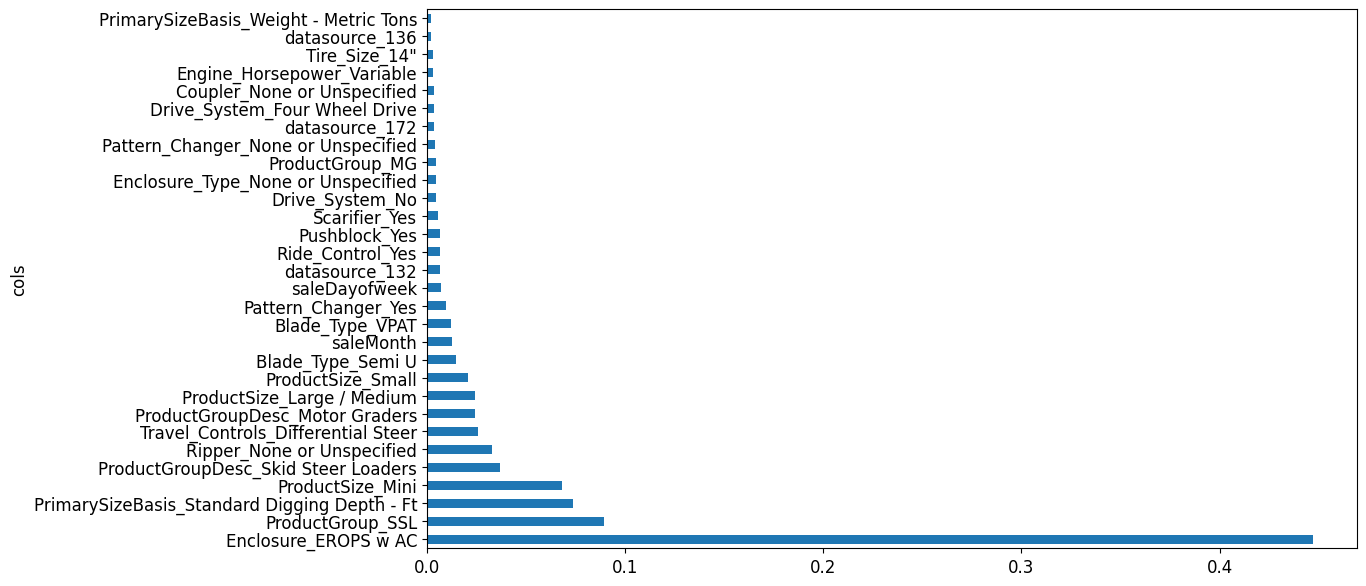

In [111]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf, X)
fi[:10]

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [132]:
cluster_columns(xs_imp)

NameError: name 'cluster_columns' is not defined

In [93]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error')

In [96]:
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence

# Fit your RandomForestRegressor model
# rf = RandomForestRegressor(...)
# rf.fit(X_train, y_train)

# Let's say you're interested in the features 'YearMade' and 'MachineHoursCurrentMeter'
features = ['YearMade', 'MachineHoursCurrentMeter']

# Create the plot
plot_partial_dependence(rf, X_train, features)
plt.suptitle('Partial dependence plots')
plt.subplots_adjust(top=0.9)  # adjust title position
plt.show()


ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/home/john/.local/lib/python3.10/site-packages/sklearn/inspection/__init__.py)

In [98]:
from sklearn.tree import export_graphviz
import graphviz

# Fit your RandomForestRegressor model
# rf = RandomForestRegressor(...)
# rf.fit(X_train, y_train)

# Choose a tree from the forest to visualize
chosen_tree = rf.estimators_[0]

# Export as dot file
export_graphviz(chosen_tree,
                out_file='tree.dot',
                rounded=True,
                proportion=False, 
                precision=2,
                filled=True)

# Convert to png using system command (requires Graphviz)
# Uncomment the line below if you're not on Windows
# !dot -Tpng tree.dot -o tree.png

# On Windows, use the following
# !dot -Tpng tree.dot -o tree.png

# Display in Jupyter notebook
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


/tmp/ipykernel_14138/374991407.py:31: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.378866 to fit


In [101]:
from IPython.core.display import display, HTML

with open("tree.dot") as f:
    dot_graph = f.read()

# Convert the dot file to png
graphviz.Source(dot_graph).render(filename="tree", format="png", cleanup=True)

# Display the png file in a scrollable div
display(HTML('<div style="width: 1000px; height: 600px; overflow: auto;"><img src="tree.png"></div>'))


/tmp/ipykernel_14138/2492744446.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.378866 to fit


In [103]:
!pip install dtreeviz

Defaulting to user installation because normal site-packages is not writeable


In [104]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(rf.estimators_[0], X_train, y_train,
               target_name="target",
               feature_names=X_train.columns)
               
viz.view()


ImportError: cannot import name 'dtreeviz' from 'dtreeviz.trees' (/home/john/.local/lib/python3.10/site-packages/dtreeviz/trees.py)

## Including Features
Which features should I include? Which can I safely omit?

One idea is to include all of them.